<a href="https://colab.research.google.com/github/ajayhukam/Policy-Optimization/blob/main/PolicyOptimizationML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Requirements**

In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gym

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score, classification_report, roc_curve, auc

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# from d3rlpy.algos import CQL
# from d3rlpy.datasets import MDPDataset

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

**Load dataset (focused columns) & initial filtering — Task 1**

In [2]:
DATA_PATH = "/content/accepted_2007_to_2018Q4.csv"
SAMPLE_FRAC = 0.25
USECOLS = [
    'loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade',
    'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
    'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'revol_util',
    'total_acc', 'open_acc', 'pub_rec', 'loan_status'
]

print("Reading CSV")
df = pd.read_csv(DATA_PATH, usecols=USECOLS, low_memory=False)
print("Original rows:", len(df))
if SAMPLE_FRAC < 1.0:
    df = df.sample(frac=SAMPLE_FRAC, random_state=SEED).reset_index(drop=True)
    print("After sampling rows:", len(df))

good_status = ['Fully Paid', 'Charged Off']
df = df[df['loan_status'].isin(good_status)].copy()
print("After status filtering (Fully Paid / Charged Off):", len(df))

display(df.head())
display(df['loan_status'].value_counts())


Reading CSV
Original rows: 39037
After sampling rows: 9759
After status filtering (Fully Paid / Charged Off): 8543


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,open_acc,pub_rec,revol_util,total_acc
0,5000.0,36 months,9.17,B,B2,10+ years,MORTGAGE,40000.0,Not Verified,Fully Paid,debt_consolidation,LA,20.25,0.0,20.0,0.0,46.8,36.0
1,35000.0,60 months,18.20,E,E1,10+ years,OWN,170000.0,Verified,Charged Off,credit_card,CA,11.88,1.0,5.0,0.0,36.5,8.0
2,9000.0,36 months,5.32,A,A1,10+ years,MORTGAGE,166400.0,Not Verified,Fully Paid,credit_card,MA,12.79,0.0,11.0,0.0,62.3,30.0
4,5000.0,36 months,8.38,B,B1,2 years,RENT,29000.0,Not Verified,Fully Paid,debt_consolidation,PA,6.89,0.0,8.0,0.0,38.1,27.0
5,12000.0,36 months,8.38,B,B1,5 years,OWN,71000.0,Source Verified,Fully Paid,credit_card,MD,4.68,0.0,10.0,0.0,35.3,37.0


,count
loan_status,
Fully Paid,6826
Charged Off,1717


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


**Target creation & simple EDA**

                      count unique                 top  freq          mean  \
loan_amnt            8543.0    NaN                 NaN   NaN  14493.693667   
term                   8543      2           36 months  6627           NaN   
int_rate             8543.0    NaN                 NaN   NaN     12.062578   
grade                  8543      7                   B  2638           NaN   
sub_grade              8543     35                  C1   595           NaN   
emp_length             8003     11           10+ years  2798           NaN   
home_ownership         8543      3            MORTGAGE  4191           NaN   
annual_inc           8543.0    NaN                 NaN   NaN  79285.614416   
verification_status    8543      3     Source Verified  3529           NaN   
loan_status            8543      2          Fully Paid  6826           NaN   
purpose                8543     12  debt_consolidation  4800           NaN   
addr_state             8543     49                  CA  1214    

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


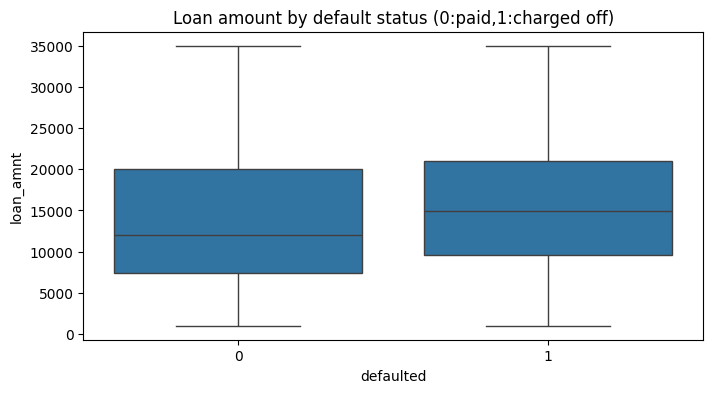

Overall default rate: 0.2009832611494791


In [3]:
df['defaulted'] = (df['loan_status'] == 'Charged Off').astype(int)

print(df.describe(include='all').T)

missing = df.isna().mean().sort_values(ascending=False)
print("Missing fraction per column:\n", missing)

plt.figure(figsize=(8,4))
sns.boxplot(x='defaulted', y='loan_amnt', data=df)
plt.title("Loan amount by default status (0:paid,1:charged off)")
plt.show()

print("Overall default rate:", df['defaulted'].mean())

**Feature cleaning helpers**

In [4]:
def parse_term(x):
    if pd.isna(x): return np.nan
    return int(x.split()[0])

def parse_percent_str(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str) and '%' in x:
        return float(x.strip().replace('%',''))/100.0
    try:
        return float(x)
    except:
        return np.nan

import re
def parse_emp_length(x):
    if pd.isna(x): return np.nan
    if x.strip() == 'n/a':
        return np.nan
    if '10+' in x:
        return 10
    if '< 1' in x:
        return 0
    m = re.search(r'(\d+)', x)
    return int(m.group(1)) if m else np.nan

df['term'] = df['term'].apply(parse_term)
df['int_rate'] = df['int_rate'].apply(parse_percent_str)
df['revol_util'] = df['revol_util'].apply(parse_percent_str)
df['emp_length'] = df['emp_length'].apply(parse_emp_length)


**Feature selection & preprocessing pipeline**

In [5]:
NUMERIC_COLS = ['loan_amnt','int_rate','annual_inc','dti','revol_util',
                'total_acc','open_acc','pub_rec','delinq_2yrs','emp_length']
CAT_COLS = ['term','grade','sub_grade','home_ownership','verification_status','purpose','addr_state']

for c in NUMERIC_COLS + CAT_COLS:
    if c not in df.columns:
        print("Warning: column missing:", c)

X_df = df[NUMERIC_COLS + CAT_COLS].copy()
y = df['defaulted'].values
loan_amnt = df['loan_amnt'].values
int_rate_decimal = df['int_rate'].values

numeric_transformer = Pipeline = None
from sklearn.pipeline import Pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, NUMERIC_COLS),
    ('cat', categorical_transformer, CAT_COLS)
], remainder='drop')

X_train_df, X_test_df, y_train, y_test, loanamnt_train, loanamnt_test, int_rate_train, int_rate_test = \
    train_test_split(X_df, y, loan_amnt, int_rate_decimal, test_size=0.20, stratify=y, random_state=SEED)

X_train_df, X_val_df, y_train, y_val, loanamnt_train, loanamnt_val, int_rate_train, int_rate_val = \
    train_test_split(X_train_df, y_train, loanamnt_train, int_rate_train, test_size=0.2, stratify=y_train, random_state=SEED)

print("Train / Val / Test sizes:", len(X_train_df), len(X_val_df), len(X_test_df))

preprocessor.fit(X_train_df)

X_train = preprocessor.transform(X_train_df)
X_val = preprocessor.transform(X_val_df)
X_test = preprocessor.transform(X_test_df)

print("Feature matrix shape (train):", X_train.shape)

Train / Val / Test sizes: 5467 1367 1709
Feature matrix shape (train): (5467, 121)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


**Supervised deep learning model (MLP) — training & evaluation**

In [6]:
def make_loader(X, y, batch_size=256, shuffle=True):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y.reshape(-1,1), dtype=torch.float32)
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train, batch_size=512, shuffle=True)
val_loader = make_loader(X_val, y_val, batch_size=1024, shuffle=False)

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128,64,32], dropout=0.2):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

input_dim = X_train.shape[1]
model = MLPClassifier(input_dim, hidden_dims=[256,128,64], dropout=0.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Using device:", device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

EPOCHS = 20
best_val_auc = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb.squeeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_train_loss = total_loss / len(train_loader.dataset)

    model.eval()
    all_logits = []
    all_y = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            logits = model(xb)
            all_logits.append(logits.cpu().numpy())
            all_y.append(yb.numpy())
    all_logits = np.concatenate(all_logits)
    all_y = np.concatenate(all_y).reshape(-1)
    probs = 1.0 / (1.0 + np.exp(-all_logits))
    val_auc = roc_auc_score(all_y, probs)
    # F1 at 0.5 threshold
    preds = (probs >= 0.5).astype(int)
    val_f1 = f1_score(all_y, preds)

    print(f"Epoch {epoch}/{EPOCHS}: train_loss={avg_train_loss:.4f}, val_auc={val_auc:.4f}, val_f1={val_f1:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_mlp.pt")


Using device: cuda
Epoch 1/20: train_loss=0.5981, val_auc=0.5555, val_f1=0.0000
Epoch 2/20: train_loss=0.5005, val_auc=0.7020, val_f1=0.0000
Epoch 3/20: train_loss=0.4675, val_auc=0.7253, val_f1=0.0000
Epoch 4/20: train_loss=0.4537, val_auc=0.7304, val_f1=0.0000


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Epoch 5/20: train_loss=0.4468, val_auc=0.7319, val_f1=0.0000
Epoch 6/20: train_loss=0.4453, val_auc=0.7317, val_f1=0.0000
Epoch 7/20: train_loss=0.4393, val_auc=0.7297, val_f1=0.0000


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Epoch 8/20: train_loss=0.4385, val_auc=0.7283, val_f1=0.0000
Epoch 9/20: train_loss=0.4333, val_auc=0.7253, val_f1=0.0000


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Epoch 10/20: train_loss=0.4324, val_auc=0.7239, val_f1=0.0692
Epoch 11/20: train_loss=0.4279, val_auc=0.7196, val_f1=0.2175
Epoch 12/20: train_loss=0.4249, val_auc=0.7168, val_f1=0.2957


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Epoch 13/20: train_loss=0.4179, val_auc=0.7157, val_f1=0.2571
Epoch 14/20: train_loss=0.4135, val_auc=0.7095, val_f1=0.2888
Epoch 15/20: train_loss=0.4053, val_auc=0.7076, val_f1=0.3174


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Epoch 16/20: train_loss=0.4000, val_auc=0.6990, val_f1=0.3077
Epoch 17/20: train_loss=0.3853, val_auc=0.7041, val_f1=0.3316
Epoch 18/20: train_loss=0.3740, val_auc=0.6947, val_f1=0.3231
Epoch 19/20: train_loss=0.3710, val_auc=0.6931, val_f1=0.3406
Epoch 20/20: train_loss=0.3556, val_auc=0.6835, val_f1=0.3418


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [7]:
model.load_state_dict(torch.load("best_mlp.pt"))
model.eval()

test_loader = make_loader(X_test, y_test, batch_size=2048, shuffle=False)
all_logits = []
all_y = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        all_logits.append(logits.cpu().numpy())
        all_y.append(yb.numpy())
all_logits = np.concatenate(all_logits)
all_y = np.concatenate(all_y).reshape(-1)
probs_test = 1.0 / (1.0 + np.exp(-all_logits))
preds_test = (probs_test >= 0.5).astype(int)

test_auc = roc_auc_score(all_y, probs_test)
test_f1 = f1_score(all_y, preds_test)
print("Supervised MLP Test AUC:", test_auc)
print("Supervised MLP Test F1 (0.5 threshold):", test_f1)
print(classification_report(all_y, preds_test, digits=4, zero_division=1))


Supervised MLP Test AUC: 0.7401470104879433
Supervised MLP Test F1 (0.5 threshold): 0.0
              precision    recall  f1-score   support

         0.0     0.7993    1.0000    0.8885      1366
         1.0     1.0000    0.0000    0.0000       343

    accuracy                         0.7993      1709
   macro avg     0.8996    0.5000    0.4442      1709
weighted avg     0.8396    0.7993    0.7101      1709



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


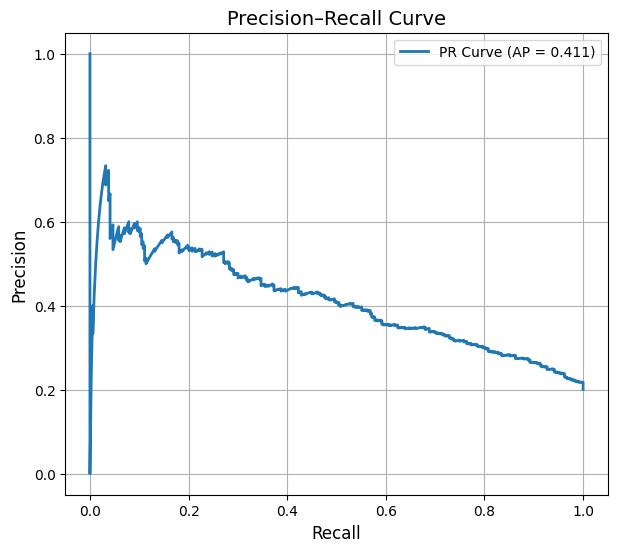

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [8]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(all_y, probs_test)
ap_score = average_precision_score(all_y, probs_test)

plt.figure(figsize=(7, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.3f})', linewidth=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision–Recall Curve', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


**Task 3: Offline RL agent (state/action/reward) + training (CQL)**

In [9]:
def compute_rewards(loan_amounts, int_rates, defaults):
    rewards = np.where(defaults == 0, loan_amounts * int_rates, -loan_amounts)
    return rewards.astype(np.float32)

rewards_train = compute_rewards(loanamnt_train, int_rate_train, y_train)
rewards_val = compute_rewards(loanamnt_val, int_rate_val, y_val)
rewards_test = compute_rewards(loanamnt_test, int_rate_test, y_test)

print("Example rewards (train):", rewards_train[:6])


Example rewards (train): [136700.  -6400. -14250.  28576.  -5000. -24175.]


**Create MDP Dataset for d3rlpy**

In [13]:
def make_offline_dataset(X_array, rewards_array):
    n = X_array.shape[0]

    obs_approve = X_array.astype(np.float32)
    acts_approve = np.ones((n,), dtype=np.int32)
    rewards_approve = rewards_array.astype(np.float32)
    terms_approve = np.ones((n,), dtype=bool)

    obs_deny = X_array.astype(np.float32)
    acts_deny = np.zeros((n,), dtype=np.int32)
    rewards_deny = np.zeros((n,), dtype=np.float32)
    terms_deny = np.ones((n,), dtype=bool)

    obs = np.vstack([obs_approve, obs_deny])
    acts = np.concatenate([acts_approve, acts_deny])
    rewards = np.concatenate([rewards_approve, rewards_deny])
    terms = np.concatenate([terms_approve, terms_deny])
    return obs, acts, rewards, terms

obs_train, acts_train, rew_train, terms_train = make_offline_dataset(X_train, rewards_train)
obs_val, acts_val, rew_val, terms_val = make_offline_dataset(X_val, rewards_val)
obs_test, acts_test, rew_test, terms_test = make_offline_dataset(X_test, rewards_test)

print("Offline dataset sizes (train obs):", obs_train.shape, acts_train.shape, rew_train.shape)


Offline dataset sizes (train obs): (10934, 121) (10934,) (10934,)


In [14]:
obs_rl = np.vstack([obs_train, obs_val])
acts_rl = np.concatenate([acts_train, acts_val])
rews_rl = np.concatenate([rew_train, rew_val])
terms_rl = np.concatenate([terms_train, terms_val])

mdp_dataset = MDPDataset(observations=obs_rl, actions=acts_rl, rewards=rews_rl, terminals=terms_rl)
print("MDPDataset created. Num transitions:", len(obs_rl))


NameError: name 'MDPDataset' is not defined

**Train a CQL (Conservative Q Learning) agent**

In [ ]:
from d3rlpy.algos import DiscreteCQLConfig
from d3rlpy.models.encoders import VectorEncoderFactory
import torch

cql_config = DiscreteCQLConfig(
    learning_rate=1e-3,
    batch_size=256,
    encoder_factory=VectorEncoderFactory(hidden_units=[256, 256]),
)

device = "cuda" if torch.cuda.is_available() else "cpu"
cql = cql_config.create(device=device)

cql.fit(
    mdp_dataset,
    n_steps=100000,
)

cql.save_model("discrete_cql_model")


**Task 4: Evaluation & Comparison**

In [ ]:
rl_actions = cql.predict(X_test.astype(np.float32))
rl_actions = np.array(rl_actions).astype(int)

est_rewards_rl = np.where(rl_actions == 1, rewards_test, 0.0)
estimated_value_rl = est_rewards_rl.mean()
print(f"RL policy estimated average reward per loan (test): {estimated_value_rl:.4f}")
print(f"Total expected profit on test (sum): {est_rewards_rl.sum():.2f} over {len(est_rewards_rl)} loans")


In [ ]:
model.eval()
with torch.no_grad():
    val_logits = model(torch.tensor(X_val, dtype=torch.float32).to(device)).cpu().numpy()
val_probs = 1.0/(1.0+np.exp(-val_logits))

thresholds = np.linspace(0.0, 1.0, 101)
best_tau = None
best_value = -1e12
for tau in thresholds:
    actions = (val_probs < tau).astype(int)
    est_rewards = np.where(actions == 1, rewards_val, 0.0)
    val = est_rewards.mean()
    if val > best_value:
        best_value = val
        best_tau = tau

print("Best validation threshold (max expected reward):", best_tau, "value:", best_value)

with torch.no_grad():
    test_logits = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()
test_probs = 1.0/(1.0+np.exp(-test_logits))
supervised_actions_test = (test_probs < best_tau).astype(int)
est_rewards_supervised = np.where(supervised_actions_test == 1, rewards_test, 0.0)
estimated_value_supervised = est_rewards_supervised.mean()
print("Supervised policy estimated avg reward (test):", estimated_value_supervised)
print("Supervised policy AUC (test):", test_auc, "F1 (0.5 threshold):", test_f1)


In [ ]:
always_approve_value = rewards_test.mean()
always_deny_value = 0.0
print("Always approve average reward:", always_approve_value)
print("Always deny average reward:", always_deny_value)

**Examples where policies differ**

In [ ]:
test_df = X_test_df.reset_index(drop=True).copy()
inspection = test_df.copy()
inspection['y_true'] = y_test
inspection['loan_amnt'] = loanamnt_test
inspection['int_rate'] = int_rate_test
inspection['reward_if_approve'] = rewards_test
inspection['supervised_action'] = supervised_actions_test
inspection['rl_action'] = rl_actions
inspection['supervised_prob_default'] = test_probs

disagree = inspection[inspection['supervised_action'] != inspection['rl_action']]
print("Number of disagreements on test:", len(disagree))
display(disagree.head(8))
